In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import dtnnlib as dtnn

In [3]:
from nflib.flows import SequentialFlow, NormalizingFlow, ActNorm
import nflib.res_flow as irf
import nflib.coupling_flows as cflow
import nflib

In [4]:
def twospirals(n_points, noise=.5, angle=784):
    """
     Returns the two spirals dataset.
    """
    n = np.sqrt(np.random.rand(n_points,1)) * angle * (2*np.pi)/360
    d1x = -np.cos(n)*n + np.random.rand(n_points,1) * noise
    d1y = np.sin(n)*n + np.random.rand(n_points,1) * noise
    return (np.vstack((np.hstack((d1x,d1y)),np.hstack((-d1x,-d1y)))), 
            np.hstack((np.zeros(n_points),np.ones(n_points))))

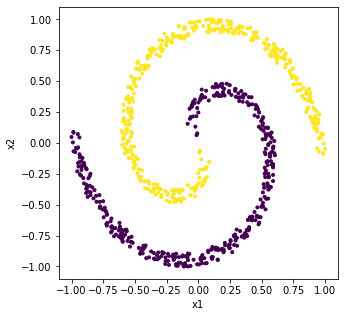

In [5]:
x, y = twospirals(400, angle=360)
x, y = x/x.max(axis=0, keepdims=True), y.reshape(-1)
xx, yy = torch.FloatTensor(x), torch.FloatTensor(y.reshape(-1,1))

x1 = xx[:,0]
x2 = xx[:,1]

%matplotlib inline
plt.figure(figsize=(5,5))
plt.scatter(x1, x2, c=y, marker='.')
plt.xlabel("x1")
plt.ylabel("x2")
plt.show()

In [6]:
class DistanceRegressor(nn.Module):
    def __init__(self, input_dim, inv_temp=1):
        super().__init__()
        self.centers = nn.Parameter(torch.rand(1, input_dim)*2-1)
        self.bias = nn.Parameter(torch.ones(1)*-0.5)
        self.inv_temp = nn.Parameter(torch.ones(1)*inv_temp)

        
    def forward(self, x):
        x = torch.norm(x-self.centers, dim=-1, keepdim=True)
        x = torch.nn.functional.softplus(x-0.1, beta=5)
#         x = -x*self.inv_temp + self.bias
        x = x*self.inv_temp + self.bias
        return x

In [7]:
# device = torch.device("cuda:0")
device = torch.device("cpu")

In [8]:
# yy = yy.reshape(-1).type(torch.long)
xx, yy = xx.to(device), yy.to(device)

## Prototype Reducers

In [9]:
# class Reducer_LearnableQuant(nn.Module):
#     def __init__(self, input_dim, num_samples):
#         self.samples = nn.Parameter(torch.randn(num_samples, input_dim))
        
#     def initialize_samples_with_data(self, samples):
#         N = self.samples.shape[0]
#         self.samples.data = samples.to(self.samples.device)[:N]
#         pass
        
#     def forward(self, x):
#         dist = torch.cdist(x, self.samples)

In [10]:
# https://github.com/MishaLaskin/vqvae/blob/master/models/quantizer.py

class VectorQuantizer(nn.Module):
    """
    Discretization bottleneck part of the VQ-VAE.

    Inputs:
    - n_e : number of embeddings
    - e_dim : dimension of embedding
    - beta : commitment cost used in loss term, beta * ||z_e(x)-sg[e]||^2
    """

    def __init__(self, num_embedding, embedding_dim, beta):
        super(VectorQuantizer, self).__init__()
        self.n_e = num_embedding
        self.e_dim = embedding_dim
        self.beta = beta

        self.embedding = nn.Embedding(self.n_e, self.e_dim)
        self.embedding.weight.data.uniform_(-1.0 / self.n_e, 1.0 / self.n_e)
        
    def initialize_embedding_with_data(self, data):
        N = self.embedding.weight.shape[0]
        assert self.embedding.weight.shape[1] == data.shape[1]
        self.embedding.weight.data = data.to(self.embedding.weight.device)[:N]
        pass

    def forward(self, z):
        """
        Inputs the output of the encoder network z and maps it to a discrete 
        one-hot vector that is the index of the closest embedding vector e_j

        z (continuous) -> z_q (discrete)

        """
        # distances from z to embeddings e_j (z - e)^2 = z^2 + e^2 - 2 e * z

#         z_flattened = z.view(-1, self.e_dim)
#         d = torch.sum(z_flattened ** 2, dim=1, keepdim=True) + \
#             torch.sum(self.embedding.weight**2, dim=1) - 2 * \
#             torch.matmul(z_flattened, self.embedding.weight.t())
        
        d = torch.cdist(z, self.embedding.weight)
        
        # find closest encodings
        min_encoding_indices = torch.argmin(d, dim=1).unsqueeze(1)
        min_encodings = torch.zeros(
            min_encoding_indices.shape[0], self.n_e).to(device)
        min_encodings.scatter_(1, min_encoding_indices, 1)
        

        # get quantized latent vectors
        z_q = torch.matmul(min_encodings, self.embedding.weight).view(z.shape)

        # compute loss for embedding
        loss = torch.mean((z_q.detach()-z)**2) + self.beta * \
            torch.mean((z_q - z.detach()) ** 2)

        # preserve gradients
        z_q = z + (z_q - z).detach()

        # perplexity
        e_mean = torch.mean(min_encodings, dim=0)
        perplexity = torch.exp(-torch.sum(e_mean * torch.log(e_mean + 1e-10)))

        return z_q, loss, perplexity #min_encodings, min_encoding_indices

In [11]:
vq = VectorQuantizer(10, 2, beta=0.25)
vq(torch.randn(3, 2))

(tensor([[-0.0771,  0.0873],
         [-0.0771,  0.0873],
         [-0.0300, -0.0474]]),
 tensor(1.4856, grad_fn=<AddBackward0>),
 tensor(1.8899))

In [12]:
gen = cflow.MLP_Generator([10])
flows = [cflow.AffineHalfFlow(2, i%2, gen) for i in range(6)]
revnet = SequentialFlow(flows)
revnet

SequentialFlow(
  (flows): ModuleList(
    (0): AffineHalfFlow(
      (s_cond): Sequential(
        (0): Linear(in_features=1, out_features=10, bias=True)
        (1): LeakyReLU(negative_slope=0.2)
        (2): Linear(in_features=10, out_features=1, bias=True)
      )
      (t_cond): Sequential(
        (0): Linear(in_features=1, out_features=10, bias=True)
        (1): LeakyReLU(negative_slope=0.2)
        (2): Linear(in_features=10, out_features=1, bias=True)
      )
    )
    (1): AffineHalfFlow(
      (s_cond): Sequential(
        (0): Linear(in_features=1, out_features=10, bias=True)
        (1): LeakyReLU(negative_slope=0.2)
        (2): Linear(in_features=10, out_features=1, bias=True)
      )
      (t_cond): Sequential(
        (0): Linear(in_features=1, out_features=10, bias=True)
        (1): LeakyReLU(negative_slope=0.2)
        (2): Linear(in_features=10, out_features=1, bias=True)
      )
    )
    (2): AffineHalfFlow(
      (s_cond): Sequential(
        (0): Linear(in_fea

In [13]:
yout = revnet.forward(xx)

In [14]:
xrec = revnet.inverse(yout)
torch.allclose(xx, xrec)

False

## Create Model

In [75]:
class Reducer_VQ(nn.Module):
    
    def __init__(self):
        super().__init__()
        gen = cflow.MLP_Generator([10], activation=nn.ELU())

#         flows = [cflow.AffineHalfFlow(2, i%2, gen) for i in range(4)]
        flows = [ActNorm(2)]
        for i in range(4):
            flows += [cflow.AffineHalfFlow(2, i%2, gen)]
#             flows += [irf.ResidualFlow(2, [10])]
            if i%2 == 1:
                flows += [ActNorm(2)]
        self.revnet = SequentialFlow(flows)

        self.vq = VectorQuantizer(20, 2, beta=0.25)
#         self.clf = nn.Linear(2, 1)
        self.clf = nn.Sequential(
                        nn.Linear(2, 3),
                        nn.ELU(),
                        nn.Linear(3, 1),)
    
        
        self.temp_xq = None
        
    def forward(self, x):
        z = self.revnet.forward(x)
#         self.vq.embedding.weight.data.clamp_(-1, 1)
        zq, qloss, perplexity= self.vq(z)
        ## moving in that direction
#         zq = 0.5*z+0.5*zq
        xq = self.revnet.inverse(zq)
        self.temp_xq = xq
        return torch.sigmoid(self.clf(xq)), qloss

In [76]:
net = Reducer_VQ().to(device)
optimizer = torch.optim.Adam(net.parameters(), lr=0.01)
criterion = nn.BCELoss()

Epoch: 99, Acc:0.71, Loss:0.5183411836624146
Epoch: 199, Acc:0.75, Loss:0.48248720169067383
Epoch: 299, Acc:0.76, Loss:0.48281800746917725
Epoch: 399, Acc:0.79, Loss:0.5051039457321167
Epoch: 499, Acc:0.64, Loss:0.5925045609474182
Epoch: 599, Acc:0.71, Loss:0.4783092737197876
Epoch: 699, Acc:0.75, Loss:0.47755786776542664
Epoch: 799, Acc:0.80, Loss:0.4946436583995819
Epoch: 899, Acc:0.77, Loss:0.5077854990959167
Epoch: 999, Acc:0.66, Loss:0.474924236536026


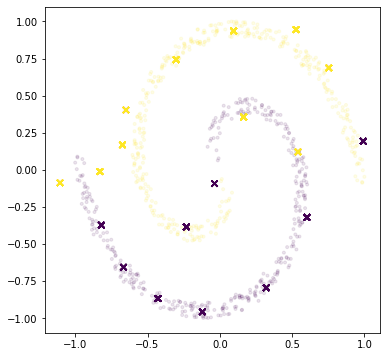

In [79]:
for epoch in range(1000):
    yout, qloss = net(xx)
    recon_loss = torch.mean((net.temp_xq - xx)**2)
    loss = criterion(yout, yy) + 0.5*qloss + 0.25*recon_loss

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch+1)%100 == 0:
        accuracy = ((yout>0.5).type(torch.float32) == yy).type(torch.float).mean()                
        print(f'Epoch: {epoch}, Acc:{float(accuracy):.2f}, Loss:{float(loss)}')

    if (epoch+1)%1000 == 0:
        ax = plt.figure(figsize=(6,6)).add_subplot()
        out = (yout.data.cpu().numpy()>0.5).astype(int)
        ax.scatter(x1, x2, c=y, marker= '.', alpha=0.1)
        ## plot centroids
        c = net.temp_xq.data.numpy()
        ax.scatter(c[:,0], c[:,1], c=out, marker= 'x')
        plt.show()

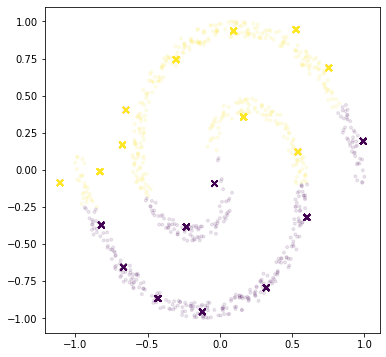

In [80]:
ax = plt.figure(figsize=(6,6)).add_subplot()
out = (yout.data.cpu().numpy()>0.5).astype(int)
ax.scatter(x1, x2, c=out, marker= '.', alpha=0.1)
## plot centroids
c = net.temp_xq.data.numpy()
ax.scatter(c[:,0], c[:,1], c=out, marker= 'x')
plt.show()

In [81]:
"""
Reduction works (in principle, but is hard to train...) in simple 2-spiral classification..
-> The quantization weights move away from valid training samples
-> The convergence is difficult to achieve for complex task. (generally gets stuck in middle)
"""

'\nReduction works (in principle, but is hard to train...) in simple 2-spiral classification..\n-> The quantization weights move away from valid training samples\n-> The convergence is difficult to achieve for complex task. (generally gets stuck in middle)\n'

## Visualize the invertible Network

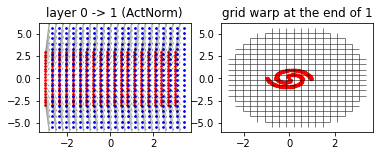

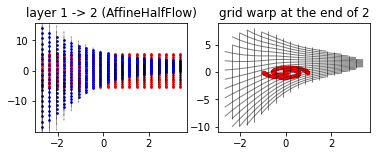

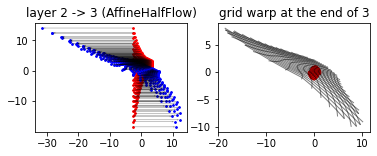

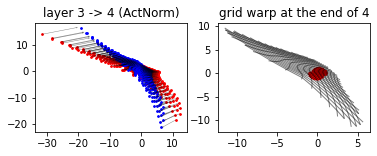

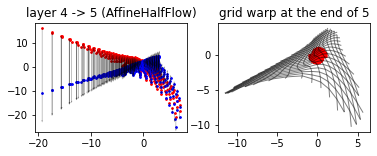

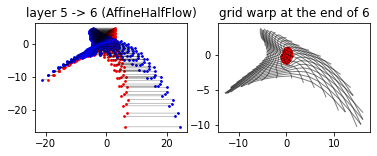

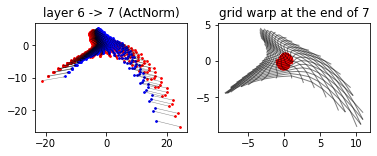

In [82]:
# Visualize the step-wise flow in the full net
from matplotlib import collections  as mc

# plot the coordinate warp
ng = 20
_xx, _yy = np.linspace(-3, 3, ng), np.linspace(-3, 3, ng)
xv, yv = np.meshgrid(_xx, _yy)
xy = np.stack([xv, yv], axis=-1)
in_circle = np.sqrt((xy**2).sum(axis=2)) <= 3 # seems appropriate since we use radial distributions as priors
xy = xy.reshape((ng*ng, 2))
xy = torch.from_numpy(xy.astype(np.float32))

# zs = net.revnet.inverse_intermediate(xy, False)
zs = net.revnet.forward_intermediate(xy, False)

backward_flow_names = [type(f).__name__ for f in net.revnet.flows[::-1]]
nz = len(zs)
for i in range(nz - 1):
    z0 = zs[i].detach().numpy()
    z1 = zs[i+1].detach().numpy()
    
    # plot how the samples travel at this stage
    figs, axs = plt.subplots(1, 2, figsize=(6, 2))
    #plt.figure(figsize=(20,10))
    axs[0].scatter(z0[:,0], z0[:, 1], c='r', s=3)
    axs[0].scatter(z1[:,0], z1[:, 1], c='b', s=3)
    axs[0].quiver(z0[:,0], z0[:,1], z1[:,0] - z0[:,0], z1[:,1] - z0[:,1], units='xy', scale=1, alpha=0.5)
#     axs[0].axis([-3, 3, -3, 3])
    axs[0].set_title("layer %d -> %d (%s)" % (i, i+1, backward_flow_names[i]))
    
    q = z1.reshape((ng, ng, 2))
    # y coords
    p1 = np.reshape(q[1:,:,:], (ng**2-ng,2))
    p2 = np.reshape(q[:-1,:,:], (ng**2-ng,2))
    inc = np.reshape(in_circle[1:,:] | in_circle[:-1,:], (ng**2-ng,))
    p1, p2 = p1[inc], p2[inc]
    lcy = mc.LineCollection(zip(p1, p2), linewidths=1, alpha=0.5, color='k')
    # x coords
    p1 = np.reshape(q[:,1:,:], (ng**2-ng,2))
    p2 = np.reshape(q[:,:-1,:], (ng**2-ng,2))
    inc = np.reshape(in_circle[:,1:] | in_circle[:,:-1], (ng**2-ng,))
    p1, p2 = p1[inc], p2[inc]
    lcx = mc.LineCollection(zip(p1, p2), linewidths=1, alpha=0.5, color='k')
    # draw the lines
    axs[1].add_collection(lcy)
    axs[1].add_collection(lcx)
#     axs[1].axis([-3, 3, -3, 3])
    axs[1].set_title("grid warp at the end of %d" % (i+1,))
    
    # draw the data too
    axs[1].scatter(x[:,0], x[:,1], c='r', s=5, alpha=0.5)

In [83]:
# type(revnet), revnet.flows

In [84]:
# revnet.inverse_intermediate()

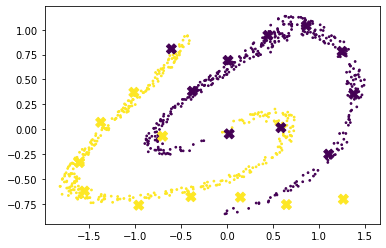

In [85]:
z = net.revnet.forward(xx, False).data
plt.scatter(z[:,0], z[:, 1], c=y, s=3)
e = net.vq.embedding.weight.data


_e = net.revnet.inverse(net.vq.embedding.weight.data)
_yout = torch.sigmoid(net.clf(_e))
_out = (_yout.data.cpu().numpy()>0.5).astype(int)

plt.scatter(e[:,0], e[:,1], c=_out.reshape(-1), s=100, marker= 'X')

In [ ]:
"""
The inputs quantize successfully, but still the DB is linear and hence can't fully classify.
- Using MLP to classify helps, however invertible function seem to provide no benefit.
"""